In [15]:
pip install opencv-python==3.4.2.16

In [16]:
pip install opencv-contrib-python==3.4.2.16

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

In [18]:
pip install SimpleITK==1.0.0

In [19]:
pip install pyradiomics

In [20]:
# select the image id (valid values 1,2,3, or 4)
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

In [21]:
from skimage import io
img1 = io.imread('THM_00078_00073.tif')
img2 = io.imread('THM_00078_00074.tif')

Text(0.5, 0, 'Train image (Image to be transformed)')

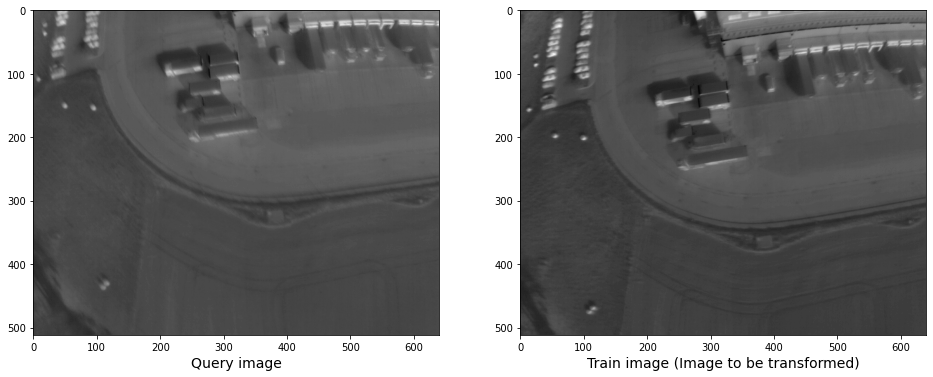

In [22]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(img1, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(img2, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

In [23]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [24]:
#sift
sift = cv2.xfeatures2d.SIFT_create()

In [25]:
image8bit1 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
image8bit2 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

In [26]:
keypoints_1, descriptors_1 = sift.detectAndCompute(image8bit1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(image8bit2,None)

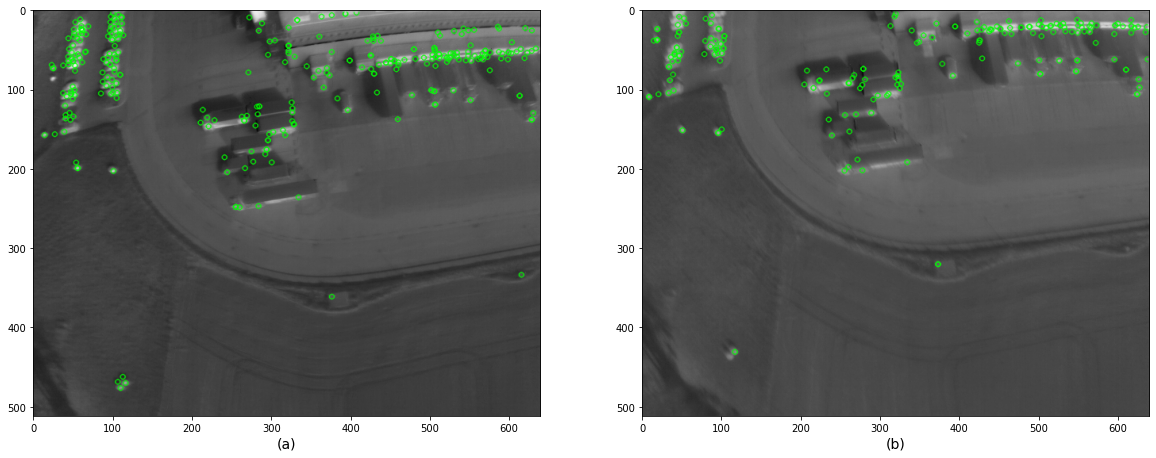

In [27]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(image8bit1,keypoints_1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(image8bit2,keypoints_2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

In [28]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [29]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [30]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

In [31]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(image8bit1,keypoints_1,image8bit2,keypoints_2,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(image8bit1,keypoints_1,image8bit2,keypoints_1,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

Using: bf feature matcher


NameError: ignored

<Figure size 1440x576 with 0 Axes>

Using: bf feature matcher


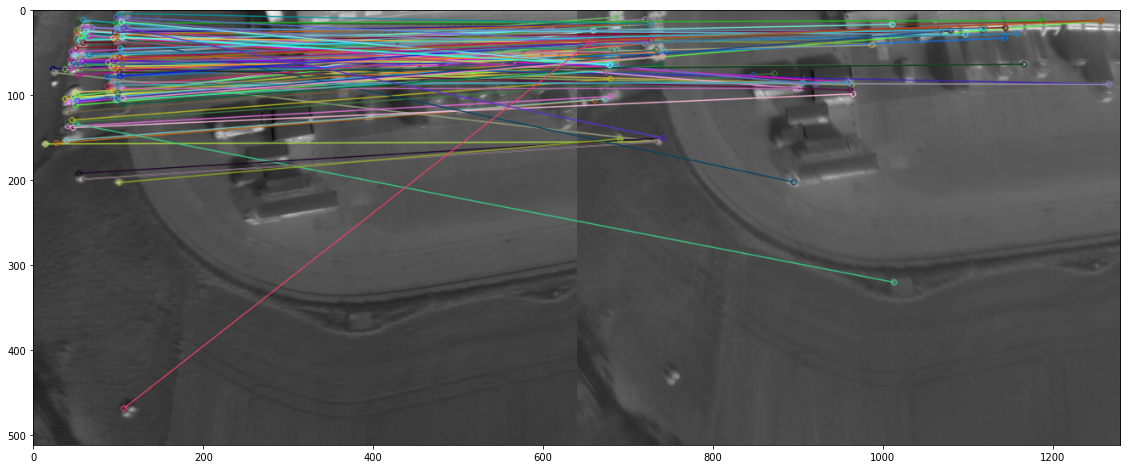

In [37]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
  bf = cv2.BFMatcher(cv2.NORM_L1,crossCheck=False) 
  matches = bf.match(descriptors_1,descriptors_2)
  img3 = cv2.drawMatches(image8bit1,keypoints_1,image8bit2,keypoints_2,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
  matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
  img3 = cv2.drawMatches(image8bit1,keypoints_1,image8bit2,keypoints_1,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


plt.imshow(img3)
plt.show()

In [38]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [40]:
M = getHomography(keypoints_1, keypoints_2, descriptors_1, descriptors_2, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 9.98465885e-01 -2.08687913e-02 -4.64141610e+00]
 [ 2.53172222e-02  9.72106218e-01 -4.97397676e+01]
 [-3.50897077e-06 -6.24419874e-05  1.00000000e+00]]


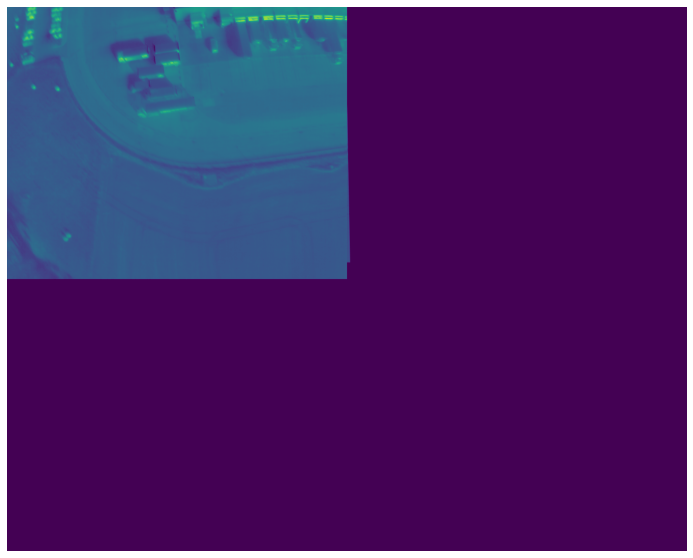

In [41]:
# Apply panorama correction
width = image8bit1.shape[1] + image8bit2.shape[1]
height = image8bit1.shape[0] + image8bit2.shape[0]

result = cv2.warpPerspective(image8bit1, H, (width, height))
result[0:image8bit2.shape[0], 0:image8bit2.shape[1]] = image8bit2

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

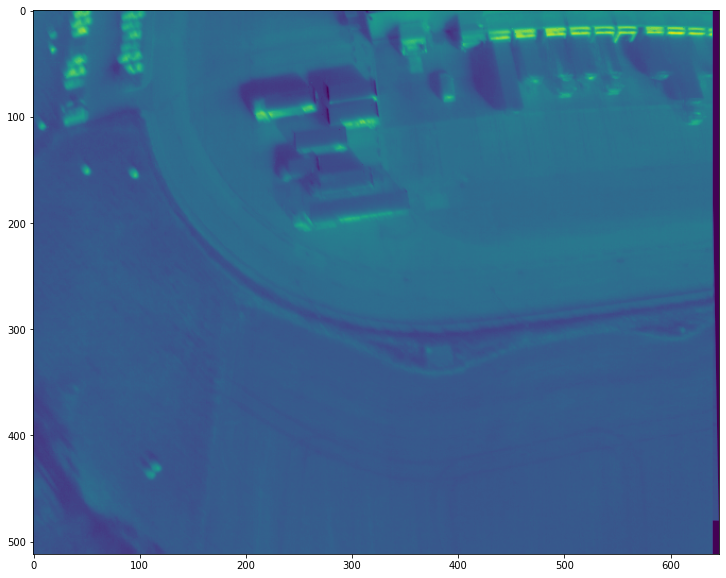

In [44]:
# transform the panorama image to grayscale and threshold it 
#gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)